#Neural Networks Homework 1
##William Harrington

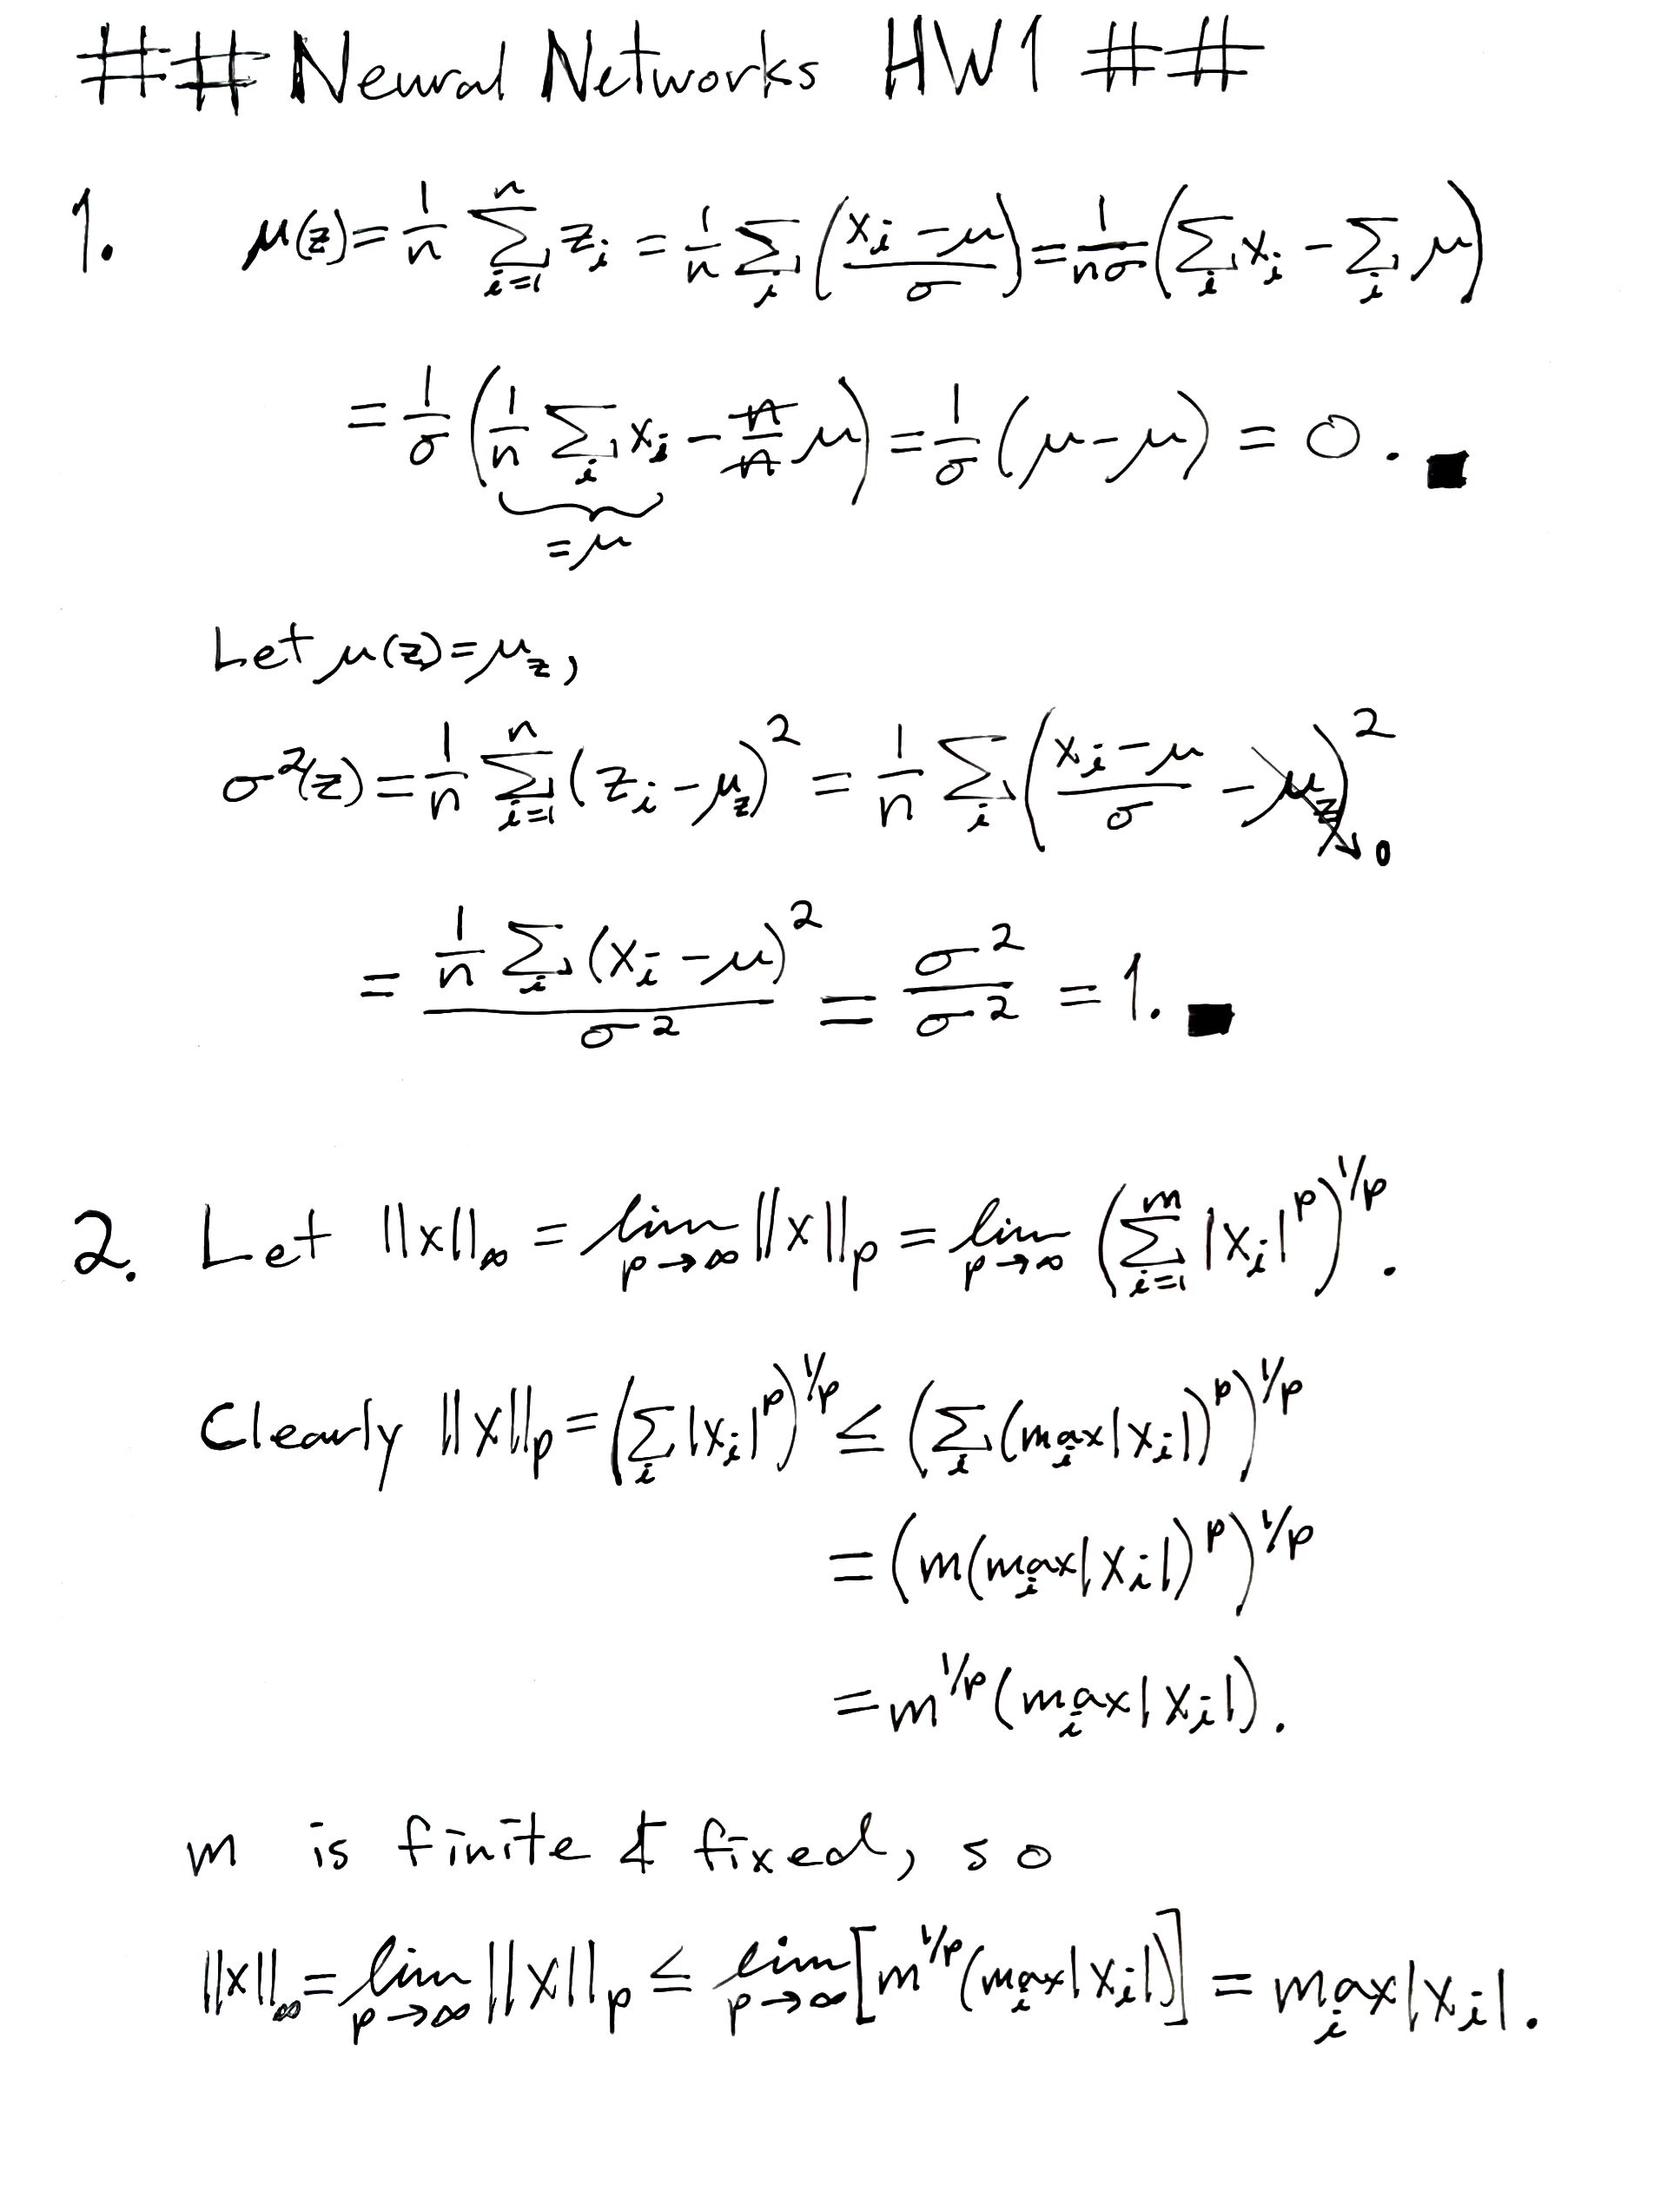

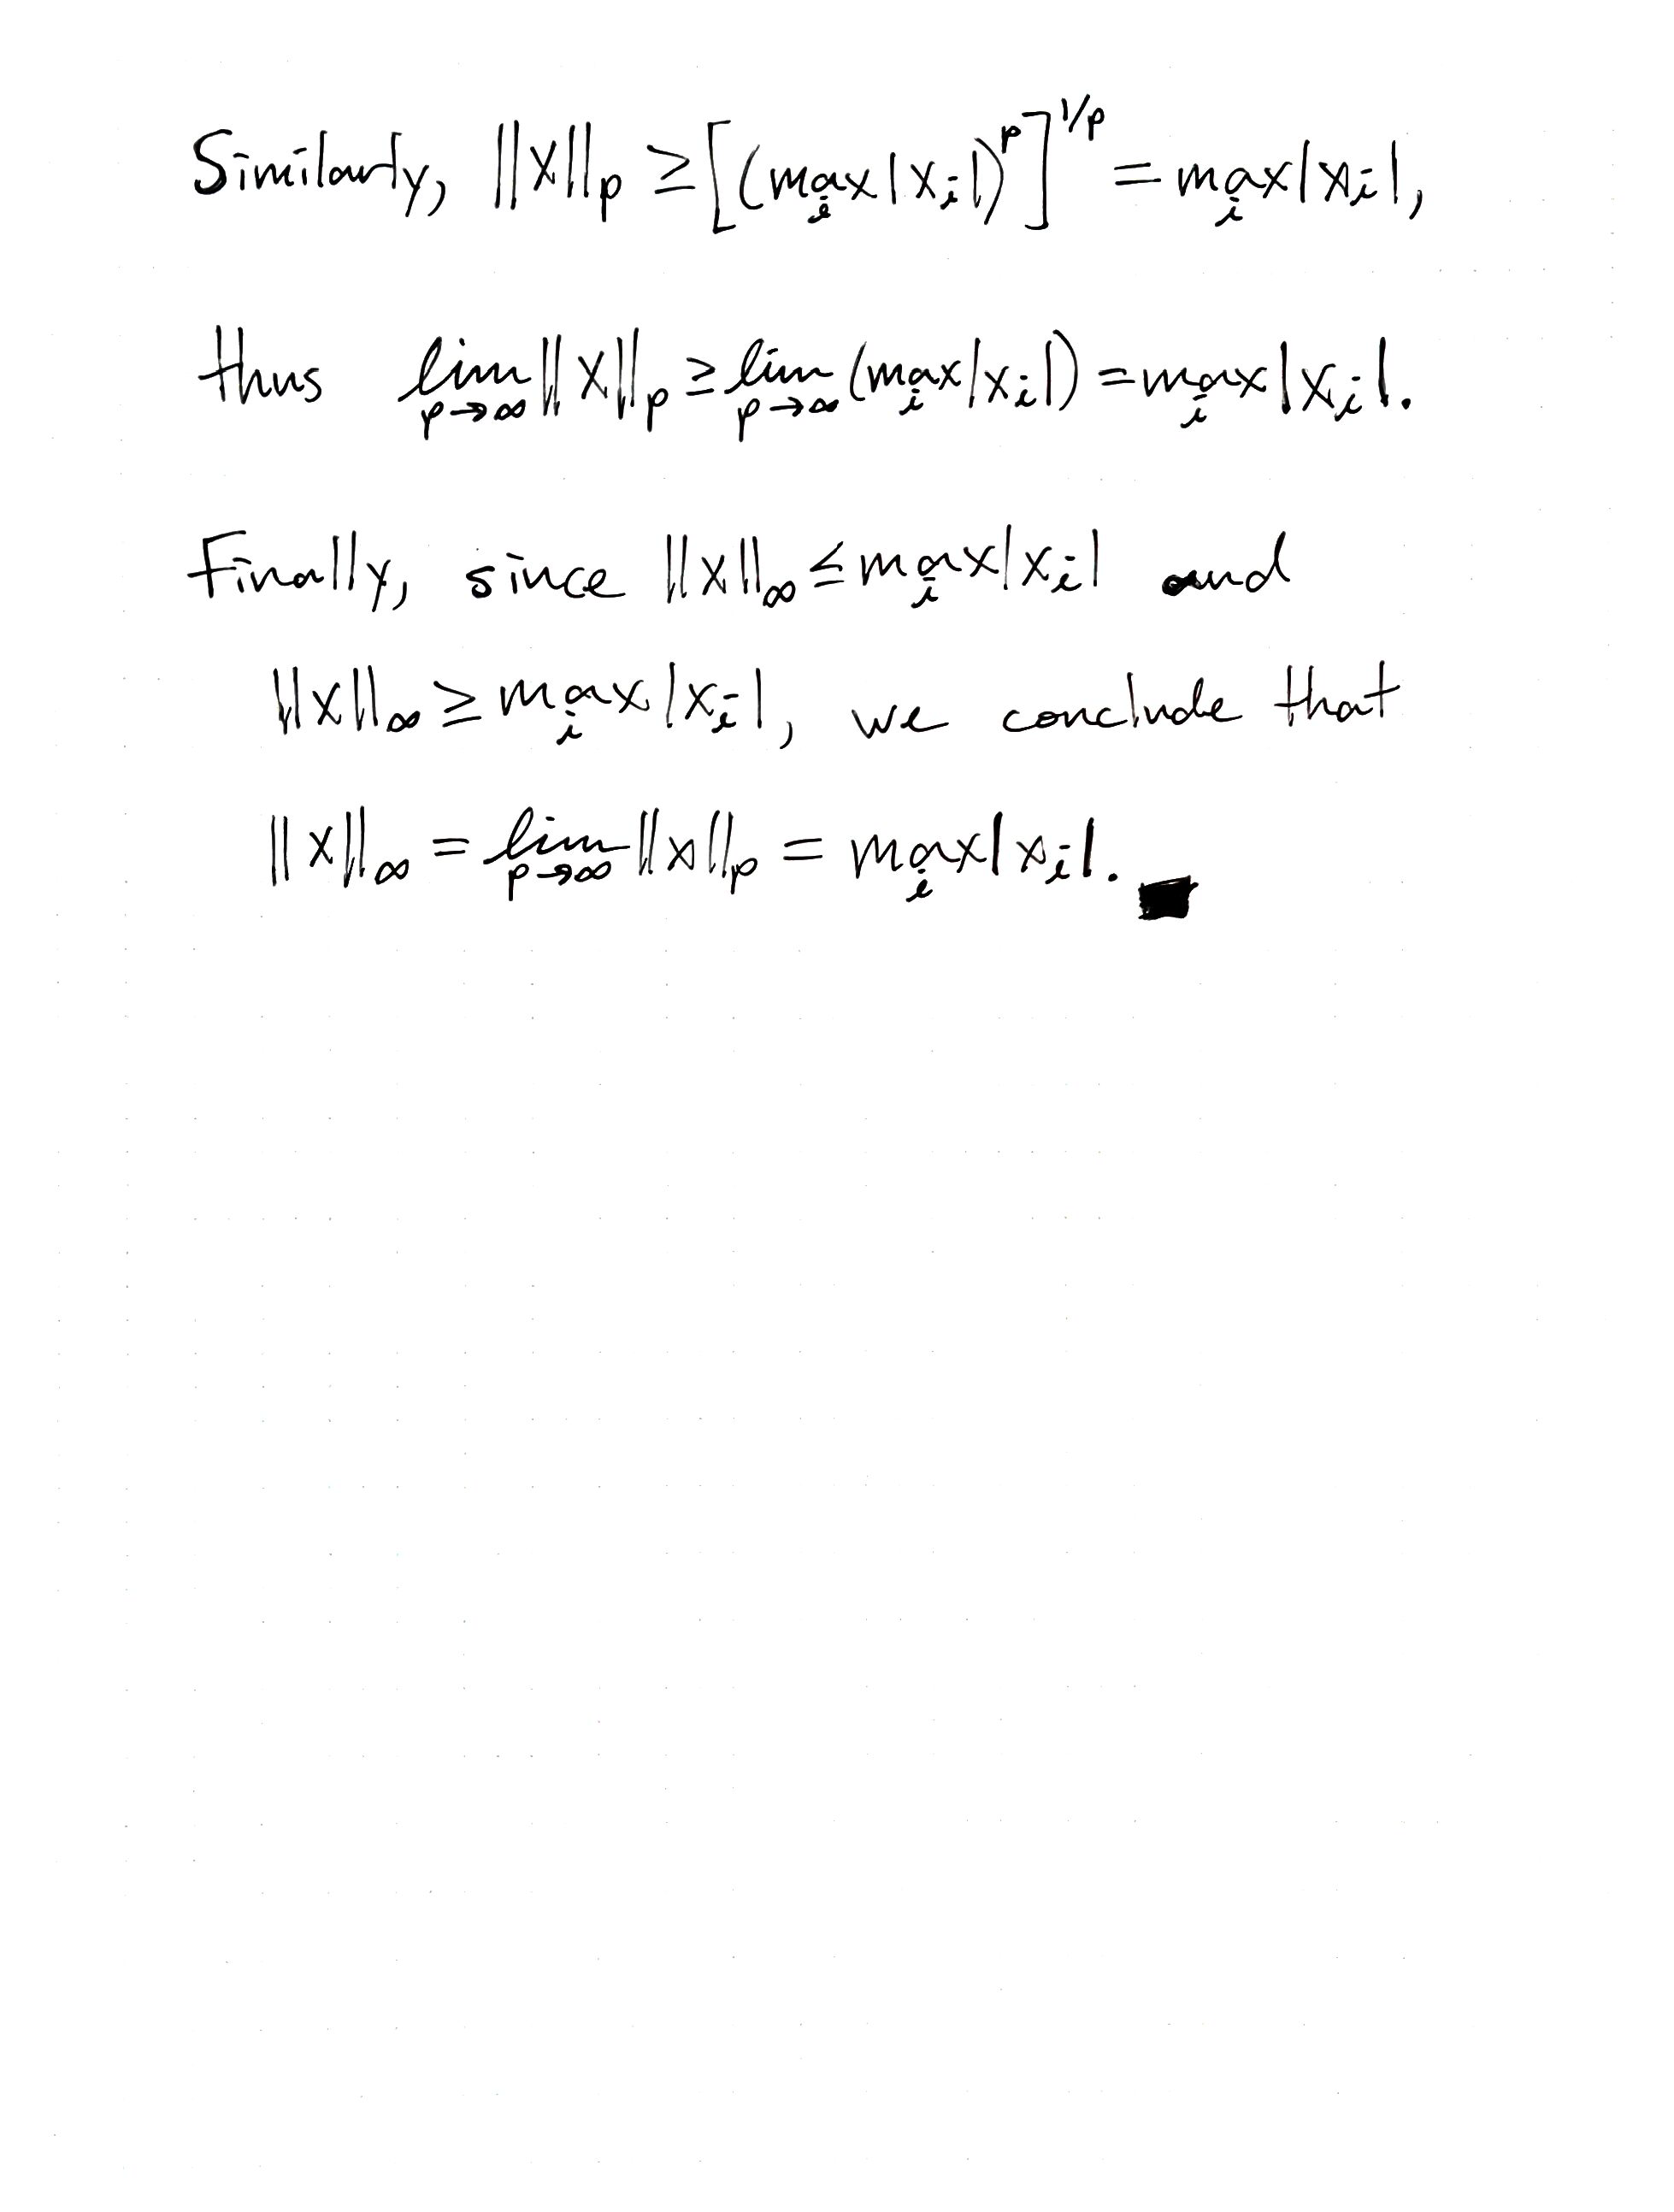

###3. k Nearest Neighbor Algorithm
*   Hyperparameters:
    *   k nearest neighbors
    *   p for Lp norm (for all p > 0)




In [ ]:
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

In [35]:
# Create a class for the k-nearest neighbor classifier
class kNearestNeighborClassifier:
    # constructor to save the hyperparameters k and p
    def __init__(self, k = 5, p = 2):
        # initialize the number of neighbors to use
        self.neighbors = k
        
        # print a warning if k is even
        #if k % 2 == 0:
        #    print('[WARNING] An odd number is recommended for k to avoid tie votes in the kNN classifier.')

        self.pnorm = p
    
    # fit the model to the training data
    def fit(self, X, y):
        '''
        Record the class labels for training data
        
        Inputs
        ------
        
        X: a matrix of datapoints from the training data, each row is a point
        y: a vector of labels for each datapoint
        
        '''
        
        # record the unique class labels
        self.classes = np.unique(y)
        
        # print a warning if we only input one class
        if self.classes.shape[0] < 2:
            print('[WARNING] There should be at least two classes in the input data.')
            
        # record the data and labels
        self.data = X
        self.labels = y
    
    # use the classifier to predict the classifications of the testing data
    def predict(self, X):
        '''
        Predict the class labels for the input data
        
        Inputs
        ------
        
        X: a matrix of datapoints from the testing data, each row is a point
        
        Outputs
        -------
        
        classes: the class predicted by the k-nearest neighbor classifier for each testing datapoint
        
        '''
        # initialize the predicted classes
        yPredicted = np.empty([X.shape[0],1])
        
        # loop over the datapoints in X
        for row in range(X.shape[0]):
            datapoint = X[row,]
            
            # find the distances from the datapoint to each training point using the Lp norm
            if self.pnorm == 'infinity':
                distances = np.amax(np.abs(self.data - datapoint), axis = 1)
            else:
                distances = (np.sum((np.abs(self.data - datapoint)**self.pnorm), axis = 1))**(1.0/self.pnorm)
            
            # find the indices of the smallest k distances
            indices = np.argsort(distances)[:self.neighbors]
            
            # find the the class labels of the nearest neighbors
            nearestClasses = self.labels[indices]
            
            # determine the predicted class by finding the mode
            yPredicted[row] = int(mode(nearestClasses)[0][0])
            
        return yPredicted

###4. CIFAR-10 Classification
1000 images are loaded, and each image's RGB data is reshaped into one row.

In [36]:
cifarData = cifar10.load_data()

# 1st index: training [0] and testing [1] data and labels
# 2nd index: datapoints [0] and labels [1]
# 3rd index: image from the set (0-49999) for training and (0-9999) for testing
# 4th index: column of RGB triples for pixels in column (0-32)
# 5th index: RGB triple for each pixel in column (0-32)
# 6th index: R for pixel, G for pixel, B for pixel (0-2)

# The datapoints are in cifarData[0][0]
X = cifarData[0][0][:1000].reshape(1000,32*32*3)
# The labels are in cifarData[0][1]
Y = cifarData[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# fit the model to the training data
model = kNearestNeighborClassifier()
model.fit(trainX,trainY)

# print the classification performance
print(classification_report(testY, model.predict(testX)))

              precision    recall  f1-score   support

           0       0.15      0.64      0.24        28
           1       0.15      0.11      0.12        28
           2       0.14      0.18      0.16        22
           3       0.43      0.10      0.16        31
           4       0.17      0.14      0.15        21
           5       0.10      0.07      0.08        14
           6       0.08      0.04      0.05        28
           7       0.67      0.06      0.11        34
           8       0.08      0.12      0.10        17
           9       0.29      0.07      0.12        27

    accuracy                           0.16       250
   macro avg       0.23      0.15      0.13       250
weighted avg       0.26      0.16      0.13       250



The above table shows the baseline results using our default k neighbors (k=5) and default p-norm (p=2, i.e. Euclidian norm).

###5. Tuning and Normalizing

First, the data is classified 400 times by varying both k and p from 1 to 20.

In [ ]:
# randomly choose 60% of the data to be the training set and 40% for the validation/testing set
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
# randomly choose 20% of the data to be the validation set and 20% for the testing set
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

# Tuning the hyperparameters
bestAccuracy = [0, 0, 0]

# loop over different values of neighbors and p-norm
for neighbors in range(1,20):
    for pnorm in range(1,20):
        # fit the model to the training data
        model = kNearestNeighborClassifier(k = neighbors, p = pnorm)
        model.fit(trainX,trainY)
    
        # measure the accuracy of the fit
        accuracy = accuracy_score(validateY, model.predict(validateX))
        #print(neighbors, accuracy)
    
        # if we find better accuracy than ever before, save it
        if accuracy > bestAccuracy[2]:
            bestAccuracy = [neighbors, pnorm, accuracy]
        
# print the accuracy
print(bestAccuracy)

[17, 15, 0.195]


The highest accuracy (19.5%) was achieved with k = 17 and p = 15.

Now the classifier is tested for k = 1 to 100 using the maximum norm (p = infinity):

In [28]:
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

bestAccuracy = [0, 0, 0]

# loop over different values of neighbors
for neighbors in range(1,100):
    # fit the model to the training data
    model = kNearestNeighborClassifier(k = neighbors, p = 'infinity')
    model.fit(trainX,trainY)
    
    # measure the accuracy of the fit
    accuracy = accuracy_score(validateY, model.predict(validateX))
    #print(neighbors, accuracy)
    
    # if we find better accuracy than ever before, save it
    if accuracy > bestAccuracy[2]:
        bestAccuracy = [neighbors, 'infinity', accuracy]
        
# print the accuracy
print(bestAccuracy)

[36, 'infinity', 0.155]


This yields the worst results yet, so the maximum norm may not be useful for classifying this data.

The data is now normalized for further tuning, first by re-scaling each datapoint from a 0 to 255 range into a 0 to 1 range.

In [37]:
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

# rescale the X values to be in [0,1]
trainX = trainX/255.0
validateX = validateX/255.0

# fit the model to the training data
model = kNearestNeighborClassifier(k = 17, p = 15)
model.fit(trainX,trainY)

# print the classification performance
print(classification_report(validateY, model.predict(validateX)))

              precision    recall  f1-score   support

           0       0.17      0.10      0.12        21
           1       0.00      0.00      0.00        25
           2       0.08      0.44      0.14        16
           3       0.00      0.00      0.00        19
           4       0.13      0.59      0.21        17
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        25
           8       0.18      0.27      0.22        15
           9       0.00      0.00      0.00        20

    accuracy                           0.12       200
   macro avg       0.06      0.14      0.07       200
weighted avg       0.05      0.12      0.06       200



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalizing the data severely worsened the accuracy using the previous best-tuned hyperparameters.

In [30]:
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

# rescale the X values to be in [0,1]
trainX = trainX/255.0
validateX = validateX/255.0

bestAccuracy = [0, 0, 0]

# loop over different values of neighbors
for neighbors in range(1,100):
    # fit the model to the training data
    model = kNearestNeighborClassifier(k = neighbors, p = 'infinity')
    model.fit(trainX,trainY)
    
    # measure the accuracy of the fit
    accuracy = accuracy_score(validateY, model.predict(validateX))
    #print(neighbors, accuracy)
    
    # if we find better accuracy than ever before, save it
    if accuracy > bestAccuracy[2]:
        bestAccuracy = [neighbors, 'infinity', accuracy]
        
# print the accuracy
print(bestAccuracy)

[28, 'infinity', 0.14]


The classifier is now also less accurate using the maximum norm.

In [38]:
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

# rescale the X values to be in [0,1]
trainX = trainX/255.0
validateX = validateX/255.0

# fit the model to the training data
model = kNearestNeighborClassifier()
model.fit(trainX,trainY)

# print the classification performance
print(classification_report(validateY, model.predict(validateX)))

              precision    recall  f1-score   support

           0       0.27      0.52      0.35        21
           1       1.00      0.12      0.21        25
           2       0.04      0.12      0.06        16
           3       0.40      0.11      0.17        19
           4       0.15      0.47      0.23        17
           5       0.00      0.00      0.00        17
           6       0.33      0.12      0.18        25
           7       0.50      0.08      0.14        25
           8       0.23      0.40      0.29        15
           9       0.67      0.10      0.17        20

    accuracy                           0.20       200
   macro avg       0.36      0.20      0.18       200
weighted avg       0.39      0.20      0.18       200



The default hyperparameters scored the highest classification accuracy so far, so the hyperparameters are looped again for values nearer to the defaults.

In [39]:
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

# rescale the X values to be in [0,1]
trainX = trainX/255.0
validateX = validateX/255.0

bestAccuracy = [0, 0, 0]

# loop over different values of neighbors and p-norm
for neighbors in range(1,10):
    for pnorm in range(1,10):
        # fit the model to the training data
        model = kNearestNeighborClassifier(k = neighbors, p = pnorm)
        model.fit(trainX,trainY)
    
        # measure the accuracy of the fit
        accuracy = accuracy_score(validateY, model.predict(validateX))
        #print(neighbors, accuracy)
    
        # if we find better accuracy than ever before, save it
        if accuracy > bestAccuracy[2]:
            bestAccuracy = [neighbors, pnorm, accuracy]
        
# print the accuracy
print(bestAccuracy)

[6, 1, 0.245]


This is a large improvement on any of the past results! The 6-nearest neighbor classifier with, interestingly, the L1 norm (i.e. taxicab distance) scored the highest classification accuracy of 24.5%.

The code block above was incredibly slow to run, at least 10x slower than the rest. I believe this is because at higher p values, inputs to the Lp formula that are < 1.0 produce very small floating point numbers after the power is evaluated, which are probably taking a long time being compared to floats many orders of magnitude larger during the sort. Ironically, it was pointless since the best p-norm was the 1-norm. It is definitely important to note, however, that certain ways to normalize data which may improve accuracy can also cause significant drops in performance for unexpected reasons.

Last, the 6-nearest neighbor classifier with L1 norm is run again using the last 20% of the data, the "test set," which was not used at all to tune the hyperparameters.

In [42]:
(trainX, tuneX, trainY, tuneY) = train_test_split(X, Y, test_size = 0.4, random_state = 1)
(validateX, testX, validateY, testY) = train_test_split(tuneX, tuneY, test_size = 0.5, random_state = 1)

trainX = trainX/255.0
testX = testX/255.0

model = kNearestNeighborClassifier(k = 6, p = 1)
model.fit(trainX,trainY)

print(classification_report(testY, model.predict(testX)))

              precision    recall  f1-score   support

           0       0.23      0.33      0.27        21
           1       0.50      0.05      0.08        22
           2       0.06      0.17      0.09        18
           3       0.07      0.06      0.06        17
           4       0.24      0.48      0.32        21
           5       0.00      0.00      0.00        10
           6       0.17      0.14      0.15        22
           7       0.60      0.12      0.21        24
           8       0.30      0.42      0.35        19
           9       0.80      0.15      0.26        26

    accuracy                           0.20       200
   macro avg       0.30      0.19      0.18       200
weighted avg       0.34      0.20      0.19       200



Disappointingly, the classifier was not able to keep the accuracy consistent and the accuracy was much lower for this data set back at just 20%. It is unsurprising though, since each of the two datasets used to test only had 200 images to cover 10 different classes. In the end, it seems it might be a better performance trade-off to use large, evenly distributed datasets than to blindly iterate through many different hyperparameter values, as I did.